In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img


## Table of contents
- [1- Problem](#1)
- [2- preparing the dataset](#2)
- [3- information about the dataset](#3)
- [4- see some examples](#4)
- [5- crate data generators](#5)
- [6- model](#6)
    - [6.1- design the model](#6.1)
    - [6.2- compile the model](#6.2)
    - [6.3- make some callbacks](#6.3)
    - [6.4- fit the model](#6.4)
- [7- evaluation](#7)

<a name='1'></a>
# 1- problem
Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

<a name='2'></a>
# 2- preparing the dataset

In [3]:
files = os.listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5")
print(len(files))

279


make a base path which contains the patient's ids

In [4]:
base_path = '../input/breast-histopathology-images/IDC_regular_ps50_idx5/'
patient_ids = os.listdir(base_path)

see how many datas belong to class_0(healthy) and how many belong to class_1(cancer)

In [5]:
class_0_total = 0
class_1_total = 0

for patient_id in patient_ids:
    class_0_files = os.listdir(base_path + patient_id + '/0')
    class_1_files = os.listdir(base_path + patient_id + '/1')

    class_0_total += len(class_0_files)
    class_1_total += len(class_1_files) 

total_images = class_0_total + class_1_total
    
print(f'Number of patches in Class 0: {class_0_total}')
print(f'Number of patches in Class 1: {class_1_total}')
print(f'Total number of patches: {total_images}')

Number of patches in Class 0: 198738
Number of patches in Class 1: 78786
Total number of patches: 277524


making a dataFrame for all of pictures. the data frame has two columns: 1-target(labels) 2-path(path of pics)

In [6]:
columns = ["target","path"]
data_rows = []

for patient_id in patient_ids:
    for c in [0,1]:
        class_path = base_path + patient_id + '/' + str(c) + '/'
        imgs = os.listdir(class_path)
        
        img_paths = [class_path + img + '/' for img in imgs]

        for path in img_paths:
            values = [c,path]
            data_rows.append({k:v for (k,v) in zip(columns,values)})

data = pd.DataFrame(data_rows)
print(data.shape)
data.head()

(277524, 2)


,target,path
0,0,../input/breast-histopathology-images/IDC_regu...
1,0,../input/breast-histopathology-images/IDC_regu...
2,0,../input/breast-histopathology-images/IDC_regu...
3,0,../input/breast-histopathology-images/IDC_regu...
4,0,../input/breast-histopathology-images/IDC_regu...


now we replace the 0 and 1 labels with healthy and canser labels

In [7]:
data['target'].replace({0:'healthy', 1:'cancer'},inplace=True)
data['path'] = data['path'].apply(lambda x: x[:-1])
data.head()

,target,path
0,healthy,../input/breast-histopathology-images/IDC_regu...
1,healthy,../input/breast-histopathology-images/IDC_regu...
2,healthy,../input/breast-histopathology-images/IDC_regu...
3,healthy,../input/breast-histopathology-images/IDC_regu...
4,healthy,../input/breast-histopathology-images/IDC_regu...


<a name='3'></a>
# 3- information about the dataset

first we group the size of data set base on the labels

In [8]:
data.groupby('target').size()

target
cancer      78786
healthy    198738
dtype: int64

know about type of each column and their size and null_count

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  277524 non-null  object
 1   path    277524 non-null  object
dtypes: object(2)
memory usage: 4.2+ MB


check if it has duplicated rows

In [10]:
data.duplicated().sum()

0

<a name='4'></a>
# 4- see some examples of the dataset

first we randomly create two dataFrames for negative(healthy) and positive(cancer) condition

In [11]:
positive = np.random.choice(data[data.target=='cancer']['path'], size=64, replace=False)
negative = np.random.choice(data[data.target=='healthy']['path'], size=64, replace=False)

these are the positive examples. means these patiens have cancer

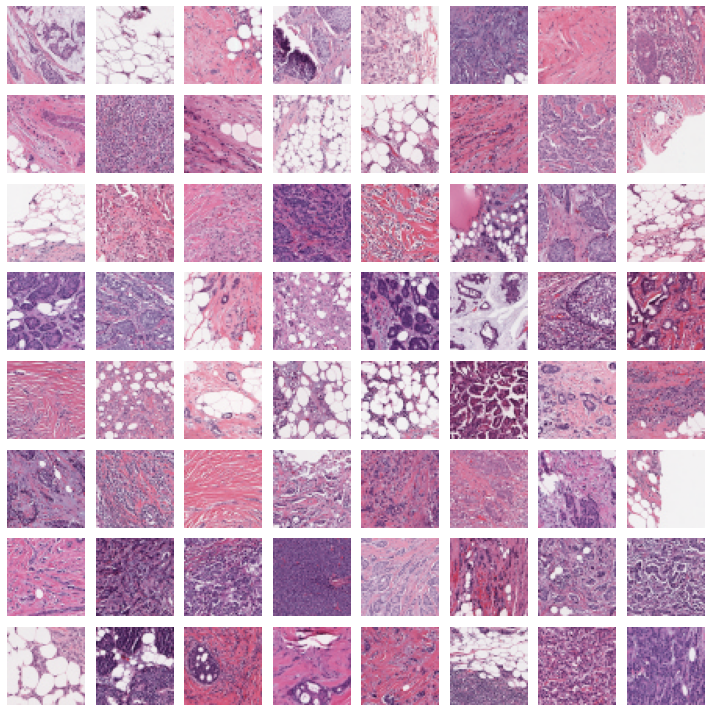

In [12]:
plt.figure(figsize=(10, 10))

for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    Img = plt.imread(positive[i])
    plt.imshow(Img)
    plt.axis("off")

and these pictures are the negative, means they are healthy.

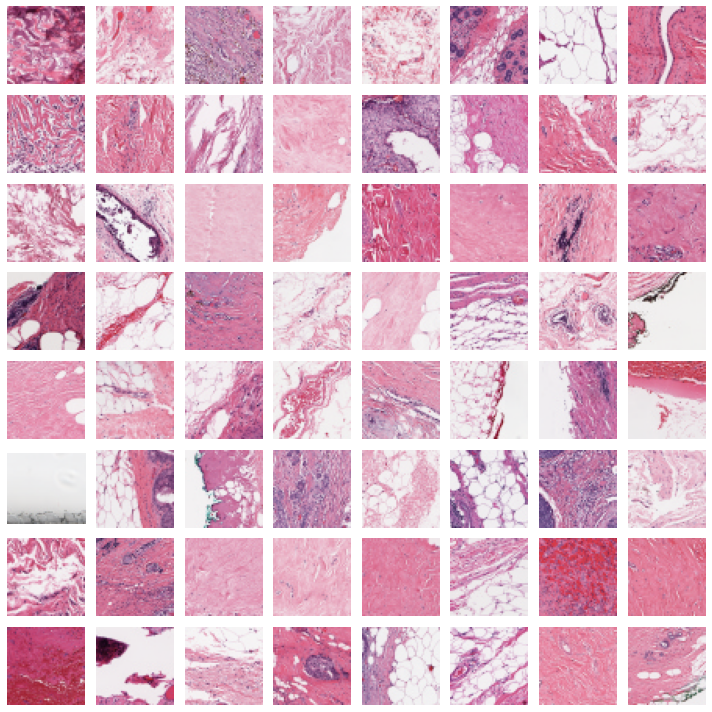

In [13]:
plt.figure(figsize=(10, 10))

for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    Img = plt.imread(negative[i])
    plt.imshow(Img)
    plt.axis("off")

<a name='5'></a>
# 5- create data generators

first we split the dataset into trainig/cross validation sets

In [14]:
import sklearn
from sklearn.model_selection import train_test_split
df_train, df_val= train_test_split(data, test_size=0.04, stratify=data['target'], random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

size of each

In [15]:
print('df_train shape is: ', df_train.shape)
print('df_val shape is: ', df_val.shape)

df_train shape is:  (266423, 2)
df_val shape is:  (11101, 2)


group each data frame's size based on the labels

In [16]:
print('number of each classes in train dataFrame is: \n', df_train.groupby('target').size())
print('number of each classes in val dataFrame is: \n',df_val.groupby('target').size())

number of each classes in train dataFrame is: 
 target
cancer      75635
healthy    190788
dtype: int64
number of each classes in val dataFrame is: 
 target
cancer     3151
healthy    7950
dtype: int64


reshape and rescale the datasets and creating data generators using ImageDataGenerator

In [17]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
)

val_datagen = ImageDataGenerator(rescale = 1.0/255.0)


# make dataset

batch_size=128
IMG_SIZE=50

train_generator = train_datagen.flow_from_dataframe(df_train, 
                                  directory = '/kaggle/working',
                                  x_col = 'path',
                                  y_col = 'target',
                                  class_mode = 'categorical',
                                  target_size = (IMG_SIZE,IMG_SIZE),
                                  batch_size = batch_size)

val_generator = val_datagen.flow_from_dataframe(df_val, 
                                  directory = '/kaggle/working',
                                  x_col = 'path',
                                  y_col = 'target',
                                  class_mode = 'categorical',
                                  target_size = (IMG_SIZE,IMG_SIZE),
                                  batch_size = batch_size)

Found 266423 validated image filenames belonging to 2 classes.
Found 11101 validated image filenames belonging to 2 classes.


<a name='6'></a>
# 6- model

<a name='6.1'></a>
## 6.1- design the model

create a CNN model using keras.sequential and aplly batchNorm and dropout regularization

In [18]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = (50,50,3)))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation = 'softmax'))

<a name='6.2'></a>
## 6.2- compile the model

complile the model using Adam optimizer, binary_crossentropy loss function

In [19]:
model.compile(
optimizer=tf.keras.optimizers.Adam(1e-3),
loss="binary_crossentropy",
metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
)

summary of the model

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        9

<a name='6.3'></a>
## 6.3- make some callbacks

save_model and Early stopping(with patience 10) callbacks

In [21]:
Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_model.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

<a name='6.4'></a>
## 6.4- fit the model

fit the model during 20 epochs and 128 batch_size

In [22]:
epochs = 20

history = model.fit(
    train_generator, epochs=epochs, callbacks=callbacks,
    validation_data= val_generator,
)

Epoch 1/20
2082/2082 [==============================] - 1358s 649ms/step - loss: 0.4192 - accuracy: 0.8339 - recall: 0.8339 - precision: 0.8339 - val_loss: 0.7207 - val_accuracy: 0.6222 - val_recall: 0.6222 - val_precision: 0.6222
Epoch 2/20
2082/2082 [==============================] - 332s 159ms/step - loss: 0.3131 - accuracy: 0.8672 - recall: 0.8672 - precision: 0.8672 - val_loss: 0.7105 - val_accuracy: 0.7620 - val_recall: 0.7620 - val_precision: 0.7620
Epoch 3/20
2082/2082 [==============================] - 335s 161ms/step - loss: 0.3028 - accuracy: 0.8727 - recall: 0.8727 - precision: 0.8727 - val_loss: 0.8621 - val_accuracy: 0.8122 - val_recall: 0.8122 - val_precision: 0.8122
Epoch 4/20
2082/2082 [==============================] - 339s 163ms/step - loss: 0.2961 - accuracy: 0.8746 - recall: 0.8746 - precision: 0.8746 - val_loss: 0.4192 - val_accuracy: 0.8090 - val_recall: 0.8090 - val_precision: 0.8090
Epoch 5/20
2082/2082 [==============================] - 275s 132ms/step - loss:

save the best model

In [23]:
model.load_weights('save_model.h5')

plot some plots of losses and accuracies

<AxesSubplot:>

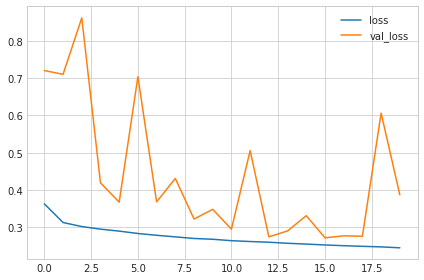

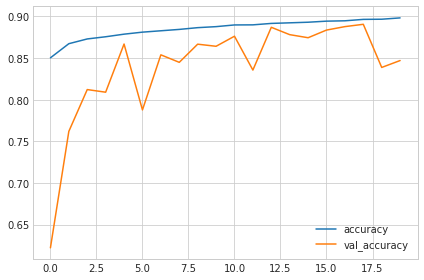

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

**in some cases we can see the model overfits, but in the end fitting was good!**

we feel we can add 12 more epochs

In [51]:
epochs = 5

model.fit(
    train_generator, epochs=epochs, callbacks=callbacks,
    validation_data= val_generator,
)

Epoch 1/5
2082/2082 [==============================] - 440s 211ms/step - loss: 0.2506 - accuracy: 0.8953 - recall: 0.8953 - precision: 0.8953 - val_loss: 0.2865 - val_accuracy: 0.8867 - val_recall: 0.8867 - val_precision: 0.8867
Epoch 2/5
2082/2082 [==============================] - 299s 143ms/step - loss: 0.2490 - accuracy: 0.8958 - recall: 0.8958 - precision: 0.8958 - val_loss: 0.3066 - val_accuracy: 0.8758 - val_recall: 0.8758 - val_precision: 0.8758
Epoch 3/5
2082/2082 [==============================] - 356s 171ms/step - loss: 0.2471 - accuracy: 0.8967 - recall: 0.8967 - precision: 0.8967 - val_loss: 0.3216 - val_accuracy: 0.8809 - val_recall: 0.8809 - val_precision: 0.8809
Epoch 4/5
2082/2082 [==============================] - 297s 143ms/step - loss: 0.2451 - accuracy: 0.8974 - recall: 0.8974 - precision: 0.8974 - val_loss: 0.5125 - val_accuracy: 0.7719 - val_recall: 0.7719 - val_precision: 0.7719
Epoch 5/5
2082/2082 [==============================] - 293s 141ms/step - loss: 0.243

In [52]:
epochs = 7

model.fit(
    train_generator, epochs=epochs, callbacks=callbacks,
    validation_data= val_generator,
)

Epoch 1/7
2082/2082 [==============================] - 291s 140ms/step - loss: 0.2415 - accuracy: 0.8994 - recall: 0.8994 - precision: 0.8994 - val_loss: 0.3392 - val_accuracy: 0.8688 - val_recall: 0.8688 - val_precision: 0.8688
Epoch 2/7
2082/2082 [==============================] - 298s 143ms/step - loss: 0.2401 - accuracy: 0.9004 - recall: 0.9004 - precision: 0.9004 - val_loss: 0.2655 - val_accuracy: 0.8925 - val_recall: 0.8925 - val_precision: 0.8925
Epoch 3/7
2082/2082 [==============================] - 293s 141ms/step - loss: 0.2377 - accuracy: 0.9008 - recall: 0.9008 - precision: 0.9008 - val_loss: 0.2745 - val_accuracy: 0.8899 - val_recall: 0.8899 - val_precision: 0.8899
Epoch 4/7
2082/2082 [==============================] - 277s 133ms/step - loss: 0.2365 - accuracy: 0.9013 - recall: 0.9013 - precision: 0.9013 - val_loss: 0.2760 - val_accuracy: 0.8854 - val_recall: 0.8854 - val_precision: 0.8854
Epoch 5/7
2082/2082 [==============================] - 272s 131ms/step - loss: 0.234

again saving the best model

In [53]:
model.load_weights('save_model.h5')

<a name='7'></a>
## 7- evaluate our model

model evaluation on the validation data generator

In [54]:
model.evaluate(val_generator)

87/87 [==============================] - 9s 100ms/step - loss: 0.2540 - accuracy: 0.8999 - recall: 0.8999 - precision: 0.8999


[0.2539891302585602,
 0.8999189138412476,
 0.8999189138412476,
 0.8999189138412476]

**we can see that we got 90% accuracy on this dataset**

predict the probabilties of each pics

In [55]:
predicts = model.predict(val_generator)

In [56]:
predicts[:5]

array([[2.0122544e-03, 9.9798775e-01],
       [5.6840707e-07, 9.9999940e-01],
       [9.5428228e-01, 4.5717761e-02],
       [5.6384397e-01, 4.3615606e-01],
       [7.5832198e-05, 9.9992418e-01]], dtype=float32)

append the predictions to the val dataFrame

In [57]:
label_p = np.argmax(predicts,axis=1)
cat=[]
for i in label_p:
    if i==0: cat.append('cancer')
    else: cat.append('healthy')
df_val['predicts'] = cat
df_val.head(10)

,target,path,predicts
0,healthy,../input/breast-histopathology-images/IDC_regu...,healthy
1,healthy,../input/breast-histopathology-images/IDC_regu...,healthy
2,healthy,../input/breast-histopathology-images/IDC_regu...,cancer
3,healthy,../input/breast-histopathology-images/IDC_regu...,cancer
4,healthy,../input/breast-histopathology-images/IDC_regu...,healthy
5,cancer,../input/breast-histopathology-images/IDC_regu...,healthy
6,healthy,../input/breast-histopathology-images/IDC_regu...,healthy
7,cancer,../input/breast-histopathology-images/IDC_regu...,healthy
8,healthy,../input/breast-histopathology-images/IDC_regu...,healthy
9,healthy,../input/breast-histopathology-images/IDC_regu...,healthy


#### now we want to see these predictions with their corresponding pictures

so we randomly split some pics of the dataset based on their labels into negative and positive dataFrames, and we use negative and positive arrays that we made above

In [58]:
neg_df = pd.DataFrame({'path':negative})
neg_df.head()

,path
0,../input/breast-histopathology-images/IDC_regu...
1,../input/breast-histopathology-images/IDC_regu...
2,../input/breast-histopathology-images/IDC_regu...
3,../input/breast-histopathology-images/IDC_regu...
4,../input/breast-histopathology-images/IDC_regu...


make a data generator for the negative(healthy) datas

In [59]:
ex = df_val.sample(64)

ex_generator = train_datagen.flow_from_dataframe(neg_df,
                                  directory = "/kaggle/working",
                                  x_col = 'path',
                                  y_col = None,
                                  target_size = (50, 50),
                                  class_mode = None)

Found 64 validated image filenames.


prediction part

In [60]:
neg_p = model.predict(ex_generator)

In [61]:
preds_neg = np.argmax(neg_p,axis=1)

now see the result on the 64 images

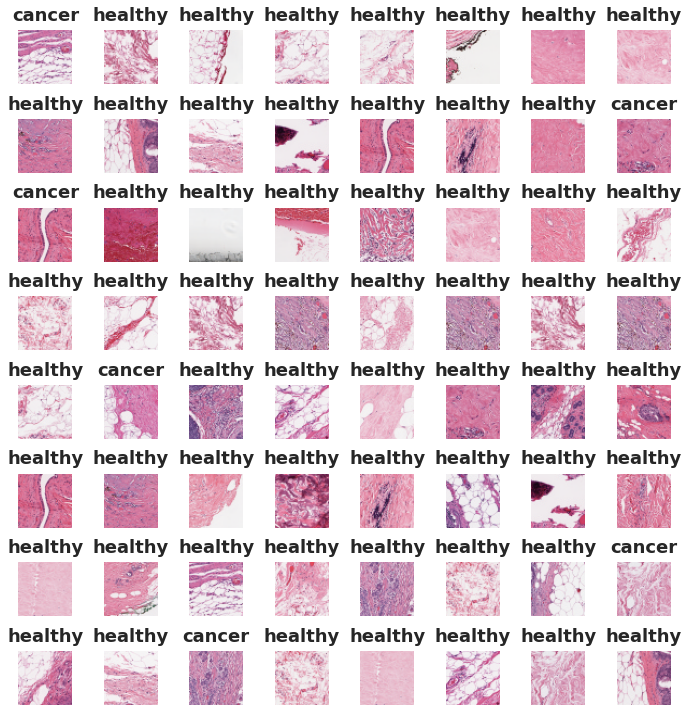

In [62]:

plt.figure(figsize=(10,10))

for i in range(64):
    plt.subplot(8, 8, i+1)
    for x_batch in ex_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.title('healthy' if preds_neg[i]==1 else 'cancer')
        plt.axis("off")
        break
plt.tight_layout()
plt.show()

now we do the same work for the positive datas(cancer state)

In [63]:
pos_df = pd.DataFrame({'path':positive})
pos_df.head()

,path
0,../input/breast-histopathology-images/IDC_regu...
1,../input/breast-histopathology-images/IDC_regu...
2,../input/breast-histopathology-images/IDC_regu...
3,../input/breast-histopathology-images/IDC_regu...
4,../input/breast-histopathology-images/IDC_regu...


Found 64 validated image filenames.


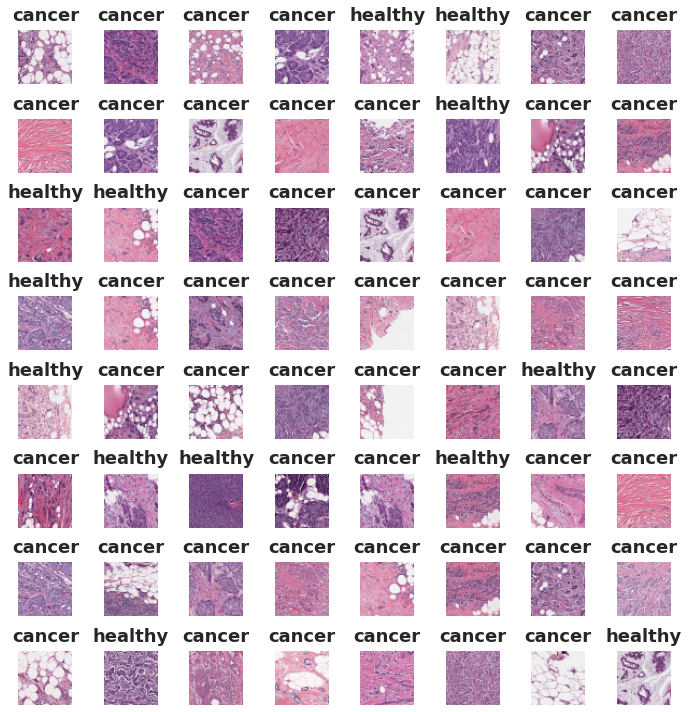

In [64]:
ex = df_val.sample(64)

ex_generator_pos = train_datagen.flow_from_dataframe(pos_df,
                                  directory = "/kaggle/working",
                                  x_col = 'path',
                                  y_col = None,
                                  target_size = (50, 50),
                                  class_mode = None)

pos_p = model.predict(ex_generator_pos)
preds_pos = np.argmax(pos_p,axis=1)

plt.figure(figsize=(10,10))

for i in range(64):
    plt.subplot(8, 8, i+1)
    for x_batch in ex_generator_pos:
        image = x_batch[0]
        plt.imshow(image)
        plt.title('healthy' if preds_pos[i]==1 else 'cancer')
        plt.axis("off")
        break
plt.tight_layout()
plt.show()

**well that's pretty good!**

this pie chart shows the percentages of the healthy and cancer records of the val dataset

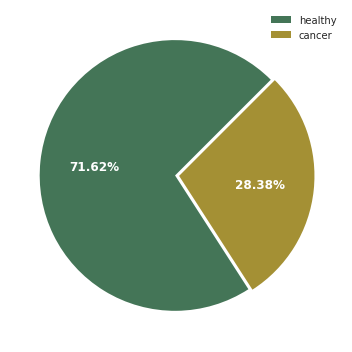

In [65]:
plt.figure(figsize=(5,5))
plt.pie(df_val['target'].value_counts(), explode=[0.01,0.02], 
       autopct="%.2f%%", textprops={'color':'white', 'size':12,
                                   'weight':'bold'},
       startangle=45, colors = ['#447557', '#A49034'])
plt.legend(["healthy","cancer"])
plt.show()

and this pie chart in bottom shows the **predictions** of our model on the val dataset

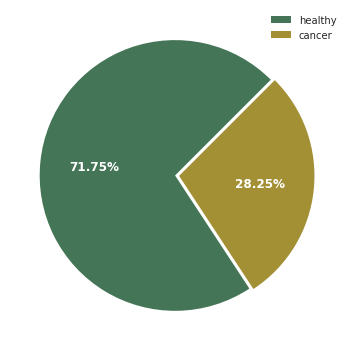

In [66]:
plt.figure(figsize=(5,5))
plt.pie(pd.DataFrame(label_p).value_counts(), explode=[0.01,0.02], 
       autopct="%.2f%%", textprops={'color':'white', 'size':12,
                                   'weight':'bold'},
       startangle=45, colors = ['#447557', '#A49034'])
plt.legend(["healthy","cancer"])
plt.show()

**we see the percantages are almost the same as our first pie chart**

#### here we check the accuracy of our model on all the nagative(healthy) and positive(cancer) separately

### 1- healthy label

In [67]:
total_negative = df_val[df_val.target == 'healthy']

ex_generator_neg_val = train_datagen.flow_from_dataframe(total_negative,
                                  directory = "/kaggle/working",
                                  x_col = 'path',
                                  y_col = 'target',
                                  target_size = (50, 50),
                                  class_mode = 'categorical')


Found 7950 validated image filenames belonging to 1 classes.


In [68]:
pred_total_neg = np.argmax(model.predict(ex_generator_neg_val), axis = 1)

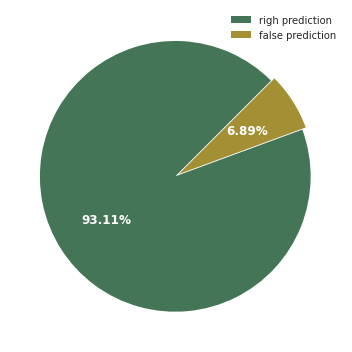

In [69]:
plt.figure(figsize=(5,5))
plt.pie(pd.DataFrame(pred_total_neg).value_counts(), explode=[0.01,0.02], 
       autopct="%.2f%%", textprops={'color':'white', 'size':12,
                                   'weight':'bold'},
       startangle=45, colors = ['#447557', '#A49034'])
plt.legend(["righ prediction","false prediction"])
plt.show()

**we can see our model correctly predicts that 93.11% of the healthy images are healthy and the model predicts 6.89% of the images are cancer which is not**

### 2- cancer label

Found 3151 validated image filenames belonging to 1 classes.


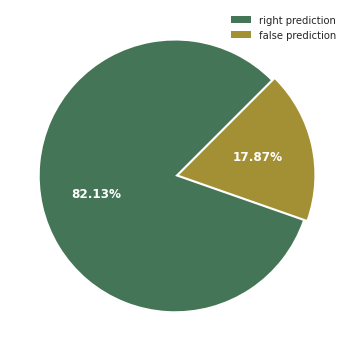

In [70]:
total_pos = df_val[df_val.target == 'cancer']

ex_generator_pos_val = train_datagen.flow_from_dataframe(total_pos,
                                  directory = "/kaggle/working",
                                  x_col = 'path',
                                  y_col = 'target',
                                  target_size = (50, 50),
                                  class_mode = 'categorical')

pred_total_pos = np.argmax(model.predict(ex_generator_pos_val), axis = 1)

plt.figure(figsize=(5,5))
plt.pie(pd.DataFrame(pred_total_pos).value_counts(), explode=[0.01,0.02], 
       autopct="%.2f%%", textprops={'color':'white', 'size':12,
                                   'weight':'bold'},
       startangle=45, colors = ['#447557', '#A49034'])
plt.legend(["right prediction","false prediction"])
plt.show()

**we can see our model correctly predicts that 82.13% of the cancer images are cancer and the model predicts 17.87% of the images are healthy which is not**